<a href="https://colab.research.google.com/github/mobarakol/computer_vision_tutorial/blob/main/Epipolar_Geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Epipolar Geometry

In [1]:
!git clone https://github.com/jagracar/OpenCV-python-tests.git
%cd OpenCV-python-tests/OpenCV-tutorials/cameraCalibration/

Cloning into 'OpenCV-python-tests'...
remote: Enumerating objects: 235, done.
remote: Total 235 (delta 0), reused 0 (delta 0), pack-reused 235
Receiving objects: 100% (235/235), 11.84 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/OpenCV-python-tests/OpenCV-tutorials/cameraCalibration


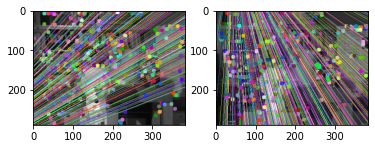

In [2]:
'''
 Based on the following tutorial:
   http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html
'''

import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load the left and right images in gray scale
imgLeft = cv2.imread('../data/tsukuba_l.png', 0)
imgRight = cv2.imread('../data/tsukuba_r.png', 0)

# Detect the SIFT key points and compute the descriptors for the two images
sift = cv2.xfeatures2d.SIFT_create()
keyPointsLeft, descriptorsLeft = sift.detectAndCompute(imgLeft, None)
keyPointsRight, descriptorsRight = sift.detectAndCompute(imgRight, None)

# Create FLANN matcher object
FLANN_INDEX_KDTREE = 0
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv2.FlannBasedMatcher(indexParams, searchParams)

# Match the descriptors (this crashes in OpenCV3.1)
# See https://github.com/Itseez/opencv/issues/5667
matches = flann.knnMatch(descriptorsLeft, descriptorsRight, k=2)

# Apply ratio test
goodMatches = []
ptsLeft = []
ptsRight = []

for m, n in matches:
    if m.distance < 0.8 * n.distance:
        goodMatches.append([m])
        ptsLeft.append(keyPointsLeft[m.trainIdx].pt)
        ptsRight.append(keyPointsRight[n.trainIdx].pt)

ptsLeft = np.int32(ptsLeft)
ptsRight = np.int32(ptsRight)
F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, cv2.FM_LMEDS)

# We select only inlier points
ptsLeft = ptsLeft[mask.ravel() == 1]
ptsRight = ptsRight[mask.ravel() == 1]

def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight.reshape(-1, 1, 2), 2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(imgLeft, imgRight, linesLeft, ptsLeft, ptsRight)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft.reshape(-1, 1, 2), 1, F)
linesRight = linesRight.reshape(-1, 3)
img3, img4 = drawlines(imgRight, imgLeft, linesRight, ptsRight, ptsLeft)

plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()